In [1]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import scipy
import iris
import iris.pandas
from iris.experimental import stratify
from iris.analysis import trajectory
import warnings
warnings.filterwarnings('ignore', module='iris')
from pathlib import Path
import dateutil.parser
from datetime import datetime, timedelta
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Scientific parameters
M_air = 28.97 # molar mass of dry air [kg]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12 # Ethane_WAS
coeff_c3h8 = (M_air/44.0956)*1e12 # Propane_WAS
coeff_nc4h10 = (M_air/58.1222)*1e12 # n-Butane_WAS
coeff_ic4h10 = (M_air/58.1222)*1e12 # i-Butane_WAS
coeff_nc5h12 = (M_air/72.1488)*1e12 # n-Pentane_WAS
coeff_ic5h12 = (M_air/72.1488)*1e12 # i-Pentane_WAS
coeff_meono2 = (M_air/77.0394)*1e12 # MeONO2_WAS
coeff_sbuono2 = (M_air/119.1192)*1e12 # 2-BuONO2_WAS or sBuONO2
coeff_n2peono2 = (M_air/133.1457)*1e12 # 2-PenONO2_WAS or n2PeONO2 or nPeBONO2
coeff_n3peono2 = (M_air/133.1457)*1e12 # 3-PenONO2_WAS or n3PeONO2 or nPeCONO2
coeff_ipeono2 = (M_air/133.1457)*1e12 # 3-Methyl-2-BuONO2_WAS or iPeONO2 or iPeBONO2
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
savefig = True
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [2]:
# Read ATom NetCDF files
path_obs_atom = Path('../../external_data/ATom/nc/data')
# Merge flights by month
flist_atom_flights = ['MER-WAS_DC8_20170218_R8.nc', 'MER-WAS_DC8_20170219_R7.nc', 'MER-WAS_DC8_20170221_R8.nc'] # and MER-WAS_DC8_20170201_R9.nc Anchorage-Kona
fpaths_atom_flights = [path_obs_atom / i for i in flist_atom_flights]
atom_dsinf = xr.open_mfdataset(fpaths_atom_flights, decode_times=True)
atom_dsmms = xr.open_mfdataset(fpaths_atom_flights, group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(fpaths_atom_flights, group='WAS', decode_cf=True)

In [47]:
# Read UKCA NetCDF files (takes some time)
ukca_run_name = 'ba083'
ukca_run_freq = 'T1H'
ukca_run_mnth = '201702'
fname_ukca_run = f'{ukca_run_name}_{ukca_run_freq}_{ukca_run_mnth}_'
path_to_ukca_run = Path('../data') / ukca_run_name / fname_ukca_run
# cb_nc4h10 = iris.load_cube(str(path_to_ukca_run)+'alkanes.nc', 'n-C4H10 MASS MIXING RATIO AFTER TS')*coeff_nc4h10
# cb_ic4h10 = iris.load_cube(str(path_to_ukca_run)+'alkanes.nc', 'i-C4H10 MASS MIXING RATIO AFTER TS')*coeff_ic4h10
cb_nc5h12 = iris.load_cube(str(path_to_ukca_run)+'alkanes.nc', 'n-C5H12 MASS MIXING RATIO AFTER TS')*coeff_nc5h12
# cb_ic5h12 = iris.load_cube(str(path_to_ukca_run)+'alkanes.nc', 'i-C5H12 MASS MIXING RATIO AFTER TS')*coeff_ic5h12
# cb_sbuono2 = iris.load_cube(str(path_to_ukca_run)+'nitrates.nc', 's-BuONO2 MASS MIXING RATIO AFTER TS')*coeff_sbuono2
cb_n2peono2 = iris.load_cube(str(path_to_ukca_run)+'nitrates.nc', 'n-2PeONO2 MASS MIXING RATIO AFTER TS')*coeff_n2peono2
# cb_n3peono2 = iris.load_cube(str(path_to_ukca_run)+'nitrates.nc', 'n-3PeONO2 MASS MIXING RATIO AFTER TS')*coeff_n3peono2
# cb_ipeono2 = iris.load_cube(str(path_to_ukca_run)+'nitrates.nc', 'i-PeONO2 MASS MIXING RATIO AFTER TS')*coeff_ipeono2
# cb_c2h6 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'C2H6 MASS MIXING RATIO AFTER TSTEP')*coeff_c2h6
# cb_c3h8 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'C3H8 MASS MIXING RATIO AFTER TSTEP')*coeff_c3h8
# cb_meono2 = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'MeONO2 MASS MIXING RATIO AFTER TSTEP')*coeff_meono2
# Load altitude coordinate
_alt_coord = iris.load_cube(str(Path('../data')/'ukca_coords_n96e_marcus_180705.nc'),'mass_fraction_of_ozone_in_air').coord('altitude')

In [5]:
# Extract datetimes from ATom and UKCA output
# ICARTT docs: 'Time is to be reported as seconds UTC from the start of the date on which measurements began. 
#               This date appears in both the file header and filename.'
t_yr = int(str(atom_dsinf.Flight_ID.values).split('_')[1][0:4])
t_mn = int(str(atom_dsinf.Flight_ID.values).split('_')[1][4:6])
t_da = int(str(atom_dsinf.Flight_ID.values).split('_')[1][6:8])
# times = []
# for i in atom_dsinf.UTC_Mid_WAS.values:
#     times.append(datetime(t_yr,t_mn,t_da,hour=0,minute=0,second=0) + timedelta(seconds=i))
# atom_date_start = times[0]
# atom_date_stop = times[-1]
atom_date_start = atom_dsinf.time[0].values.astype('<M8[us]').astype(datetime)
atom_date_stop = atom_dsinf.time[-1].values.astype('<M8[us]').astype(datetime)
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
ukca_days_since = dateutil.parser.parse(str(cb_n2peono2.coord('t').units)[11:])
_ukca_datetime = []
for i, ii in enumerate(list(cb_n2peono2.coord('t').points)):
    _ukca_datetime.append(ukca_days_since + timedelta(days=float(f'{ii:1.3f}'))) # following UKCA's days since 1960-09-01 format with 3 decimal places
ukca_datetime = np.array(_ukca_datetime, dtype=datetime)

In [6]:
# Path to results
atom_ukca_datetime_match = f'{atom_date_start.strftime("%y%m%d")}_{atom_date_stop.strftime("%y%m%d")}_{ukca_datetime[0].strftime("%y%m")}_merge'
path_to_results = Path('../../../results') / ukca_run_name / atom_ukca_datetime_match
path_to_results.mkdir(exist_ok=True) # create a new folder if it doesn't exist
print(atom_ukca_datetime_match)

170218_170221_1702_merge


#### Interpolate model data from hybrid height to absolute height 

In [ ]:
# a = iris.load_cube(str(Path('../data')/'ukca_coords_n96e_marcus_180705.nc'),'mass_fraction_of_ozone_in_air')
# a.coord('longitude')[106:-4].points
# cb_nc4h10.coord('longitude').points == a.coord('longitude')[106:-4].points
# a.coord('latitude')[84:144].points
# cb_nc4h10.coord('latitude').points == a.coord('latitude')[84:144].points

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()), facecolor='w')
# ax.contourf(cb_nc4h10.coord('longitude').points, cb_nc4h10.coord('latitude').points, cb_nc4h10[0,0,...].data, transform=ccrs.PlateCarree())
# ax.coastlines()

In [48]:
# Manually select the extend of the altitude coordinate that matches the extend of the ba083 UKCA run
alt_coord = _alt_coord[0:44,84:144,106:-4]
# Add altitude coordinate to the cube with model data
# cb_c2h6.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_c3h8.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_nc4h10.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_ic4h10.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_nc5h12.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_ic5h12.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_meono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_sbuono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
cb_n2peono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_n3peono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])
# cb_ipeono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])

In [8]:
import timeit

In [49]:
# # Relevel model data from hybrid_height to target levels using alt_coord
start_time = timeit.default_timer()
tgt_levels = np.arange(0, 14000, 100) # [meters]
# # cbr_c2h6 = stratify.relevel(cb_c2h6, alt_coord, tgt_levels, axis='Hybrid height')
# # cbr_c3h8 = stratify.relevel(cb_c3h8, alt_coord, tgt_levels, axis='Hybrid height')
#    cbr_nc4h10 = stratify.relevel(cb_nc4h10, alt_coord, tgt_levels, axis='Hybrid height')
# cbr_ic4h10 = stratify.relevel(cb_ic4h10, alt_coord, tgt_levels, axis='Hybrid height')
cbr_nc5h12 = stratify.relevel(cb_nc5h12, alt_coord, tgt_levels, axis='Hybrid height')
# cbr_ic5h12 = stratify.relevel(cb_ic5h12, alt_coord, tgt_levels, axis='Hybrid height')
# # cbr_meono2 = stratify.relevel(cb_meono2, alt_coord, tgt_levels, axis='Hybrid height')
#    cbr_sbuono2 = stratify.relevel(cb_sbuono2, alt_coord, tgt_levels, axis='Hybrid height')
#         cbr_n2peono2 = stratify.relevel(cb_n2peono2, alt_coord, tgt_levels, axis='Hybrid height')
# cbr_n3peono2 = stratify.relevel(cb_n3peono2, alt_coord, tgt_levels, axis='Hybrid height')
# cbr_ipeono2 = stratify.relevel(cb_ipeono2, alt_coord, tgt_levels, axis='Hybrid height')
elapsed = timeit.default_timer() - start_time
elapsed

55.29963392799982

#### Interpolate releved model data to flight track

In [10]:
# Construct 3D flights trajectory
sample_lats = atom_dsmms.G_LAT.data 
sample_lons = atom_dsmms.G_LONG.data+360
sample_alts = atom_dsmms.G_ALT.data
sample_time = np.array([(i - ukca_days_since).total_seconds() / 86400. for i in atom_datetime])
sample_time_lats_lons_alts = [('t', sample_time), ('latitude', sample_lats), ('longitude', sample_lons), ('altitude', sample_alts)]

In [50]:
start_time = timeit.default_timer()
# Interpolate model data to flights trajectory (takes some time)
# traj3d_cbr_c2h6 = trajectory.interpolate(cbr_c2h6, sample_time_lats_lons_alts)
# traj3d_cbr_c3h8 = trajectory.interpolate(cbr_c3h8, sample_time_lats_lons_alts)
#     traj3d_cbr_nc4h10 = trajectory.interpolate(cbr_nc4h10, sample_time_lats_lons_alts)
# traj3d_cbr_ic4h10 = trajectory.interpolate(cbr_ic4h10, sample_time_lats_lons_alts)
traj3d_cbr_nc5h12 = trajectory.interpolate(cbr_nc5h12, sample_time_lats_lons_alts)
# traj3d_cbr_ic5h12 = trajectory.interpolate(cbr_ic5h12, sample_time_lats_lons_alts)
# # traj3d_cbr_meono2 = trajectory.interpolate(cbr_meono2, sample_time_lats_lons_alts)
#     traj3d_cbr_sbuono2 = trajectory.interpolate(cbr_sbuono2, sample_time_lats_lons_alts)
traj3d_cbr_n2peono2 = trajectory.interpolate(cbr_n2peono2, sample_time_lats_lons_alts)
# traj3d_cbr_n3peono2 = trajectory.interpolate(cbr_n3peono2, sample_time_lats_lons_alts)
# traj3d_cbr_ipeono2 = trajectory.interpolate(cbr_ipeono2, sample_time_lats_lons_alts)
elapsed = timeit.default_timer() - start_time
elapsed/60

14.98276294795002

#### Time series of concentrations along flight track

In [ ]:
# # Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
# atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
# atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3

In [12]:
# Time series and cross section plotting parameters
if atom_ukca_datetime_match == '170218_170221_1702_merge':
    flght_separators = [149, 308] # manually select indices of flight start times in a merge
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 50) # manually choose frequency of datetimes for xticklabels
slct_time_lbls = [i.strftime('%H:%M\n%d-%m-%Y') for i in atom_dsinf.time.values[slct_time_inds].astype('<M8[us]').astype(datetime)]
print(slct_time_inds, atom_dsinf.time.shape)

[  0  50 100 150 200 250 300 350 400] (435,)


In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas_c2h6, color='k')
ax.plot(traj3d_cbr_c2h6.data.squeeze()*2, color='r')
# common
ax.set_title(f'{str_c2h6}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptvC')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C2.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas_c3h8, color='k')
ax.plot(traj3d_cbr_c3h8.data.squeeze()*3, color='r')
# common
ax.set_title(f'{str_c3h8}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptvC')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C3.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['n-Butane_WAS'], color='k')
ax.plot(traj3d_cbr_nc4h10.data.squeeze(), color='r')
# common
ax.set_title(f'{str_nc4h10}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C4n.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['i-Butane_WAS'], color='k')
ax.plot(traj3d_cbr_ic4h10.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ic4h10}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C4i.png', bbox_inches='tight')

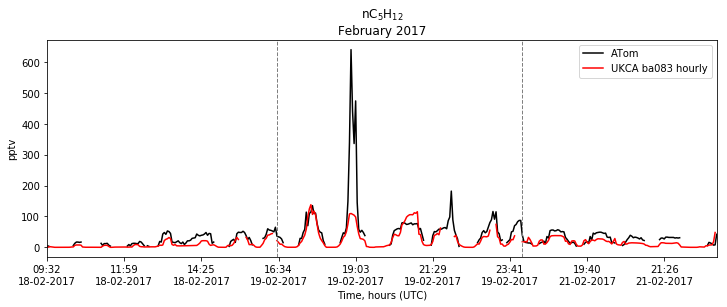

In [51]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['n-Pentane_WAS'], color='k')
ax.plot(traj3d_cbr_nc5h12.data.squeeze(), color='r')
# common
ax.set_title(f'{str_nc5h12}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C5n.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['i-Pentane_WAS'], color='k')
ax.plot(traj3d_cbr_ic5h12.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ic5h12}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RH_C5i.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['MeONO2_WAS'], color='k')
ax.plot(traj3d_cbr_meono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_meono2}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C1.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['2-BuONO2_WAS'], color='k')
ax.plot(traj3d_cbr_sbuono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_sbuono2}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C4s.png', bbox_inches='tight')

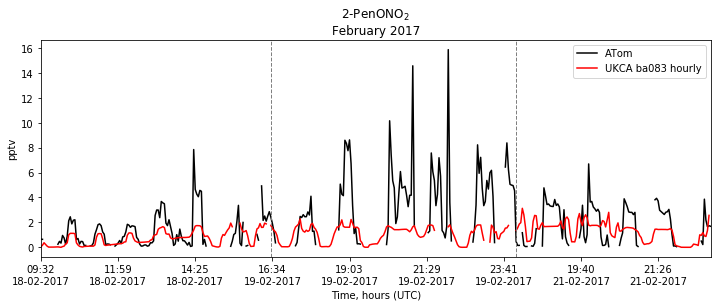

In [15]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['2-PenONO2_WAS'], color='k')
ax.plot(traj3d_cbr_n2peono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_n2peono2}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C5nB.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['3-PenONO2_WAS'], color='k')
ax.plot(traj3d_cbr_n3peono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_n3peono2}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C5nC.png', bbox_inches='tight')

In [ ]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['3-Methyl-2-BuONO2_WAS'], color='k')
ax.plot(traj3d_cbr_ipeono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ipeono2}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_C5i.png', bbox_inches='tight')

#### ATom/UKCA along flight track

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, ax = plt.subplots(figsize=(12, 4), facecolor='w');
# ax.plot(atom_dswas_c2h6/(traj3d_cbr_c2h6.data.squeeze()*2), color='k');
# # common
# ax.set_title(f'{str_c2h6}');
# ax.set_xlabel('Time, hours (UTC)');
# ax.set_ylabel('pptvC/pptvC');
# ax.set_xticks(slct_time_inds)
# ax.set_xticklabels(slct_time_lbls)
# for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# ax.legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RH_C2.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, ax = plt.subplots(figsize=(12, 4), facecolor='w');
# ax.plot(atom_dswas_c3h8/(traj3d_cbr_c3h8.data.squeeze()*3), color='k');
# # common
# ax.set_title(f'{str_c3h8}');
# ax.set_xlabel('Time, hours (UTC)');
# ax.set_ylabel('pptvC/pptvC');
# ax.set_xticks(slct_time_inds)
# ax.set_xticklabels(slct_time_lbls)
# for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# ax.legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RH_C3.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4), facecolor='w');
# axes[0].plot(atom_dswas['n-Butane_WAS']/traj3d_cbr_nc4h10.data.squeeze(), color='k')#, linestyle='None', marker='o');
# axes[1].plot(atom_dswas['n-Butane_WAS']/traj3d_cbr_nc4h10.data.squeeze(), color='k')#, linestyle='None', marker='o');
# axes[1].set_ylim(-1,10);
# # common
# ax.set_title(f'{str_nc4h10}');
# axes[1].set_xlabel('Time, hours (UTC)');
# axes[1].set_xticks(slct_time_inds)
# axes[1].set_xticklabels(slct_time_lbls)
# axes[0].set_xticklabels([])
# axes[0].set_ylabel('pptv/pptv');
# axes[1].set_ylabel('pptv/pptv');
# for x in flght_separators:
#     for ax in axes.flatten():
#         ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# axes[0].legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RH_C4n.png', bbox_inches='tight')

In [ ]:
# no i-butane

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4), facecolor='w');
# axes[0].plot(atom_dswas['n-Pentane_WAS']/traj3d_cbr_nc5h12.data.squeeze(), color='k')#, linestyle='None', marker='o')
# axes[1].plot(atom_dswas['n-Pentane_WAS']/traj3d_cbr_nc5h12.data.squeeze(), color='k')#, linestyle='None', marker='o')
# axes[1].set_ylim(-1,10);
# # common
# axes[0].set_title(f'{str_nc5h12}');
# axes[1].set_xlabel('Time, hours (UTC)');
# axes[1].set_xticks(slct_time_inds)
# axes[1].set_xticklabels(slct_time_lbls)
# axes[0].set_xticklabels([])
# axes[0].set_ylabel('pptv/pptv');
# axes[1].set_ylabel('pptv/pptv');
# for x in flght_separators:
#     for ax in axes.flatten():
#         ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# axes[0].legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RH_C5n.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4), facecolor='w');
# axes[0].plot(atom_dswas['i-Pentane_WAS']/traj3d_cbr_ic5h12.data.squeeze(), color='k')#, linestyle='None', marker='o')
# axes[1].plot(atom_dswas['i-Pentane_WAS']/traj3d_cbr_ic5h12.data.squeeze(), color='k')#, linestyle='None', marker='o')
# axes[1].set_ylim(-1,10);
# # common
# axes[0].set_title(f'{str_ic5h12}');
# axes[1].set_xlabel('Time, hours (UTC)');
# axes[1].set_xticks(slct_time_inds)
# axes[1].set_xticklabels(slct_time_lbls)
# axes[0].set_xticklabels([])
# axes[0].set_ylabel('pptv/pptv');
# axes[1].set_ylabel('pptv/pptv');
# for x in flght_separators:
#     for ax in axes.flatten():
#         ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# axes[0].legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RH_C5i.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, ax = plt.subplots(figsize=(12, 4), facecolor='w');
# ax.plot(atom_dswas['MeONO2_WAS']/traj3d_cbr_meono2.data.squeeze(), color='k')#, linestyle='None', marker='o')
# # common
# ax.set_title(f'{str_meono2}');
# ax.set_xlabel('Time, hours (UTC)');
# ax.set_ylabel('pptv/pptv');
# ax.set_xticks(slct_time_inds)
# ax.set_xticklabels(slct_time_lbls)
# for x in flght_separators:
#     ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# ax.legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RONO2_C1.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, ax = plt.subplots(figsize=(12, 4), facecolor='w');
# ax.plot(atom_dswas['2-BuONO2_WAS']/traj3d_cbr_sbuono2.data.squeeze(), color='k')#, linestyle='None', marker='o')
# # common
# ax.set_title(f'{str_sbuono2}');
# ax.set_xlabel('Time, hours (UTC)');
# ax.set_ylabel('pptv/pptv');
# ax.set_xticks(slct_time_inds)
# ax.set_xticklabels(slct_time_lbls)
# for x in flght_separators:
#     ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# ax.legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RONO2_C4s.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, ax = plt.subplots(figsize=(12, 4), facecolor='w');
# ax.plot(atom_dswas['2-PenONO2_WAS']/traj3d_cbr_n2peono2.data.squeeze(), color='k')#, linestyle='None', marker='o')
# # common
# ax.set_title(f'{str_n2peono2}');
# ax.set_xlabel('Time, hours (UTC)');
# ax.set_ylabel('pptv/pptv');
# ax.set_xticks(slct_time_inds)
# ax.set_xticklabels(slct_time_lbls)
# for x in flght_separators:
#     ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# ax.legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RONO2_C5nB.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, ax = plt.subplots(figsize=(12, 4), facecolor='w');
# ax.plot(atom_dswas['3-PenONO2_WAS']/traj3d_cbr_n3peono2.data.squeeze(), color='k')#, linestyle='None', marker='o')
# # common
# ax.set_title(f'{str_n3peono2}');
# ax.set_xlabel('Time, hours (UTC)');
# ax.set_ylabel('pptv/pptv');
# ax.set_xticks(slct_time_inds)
# ax.set_xticklabels(slct_time_lbls)
# for x in flght_separators:
#     ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# ax.legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RONO2_C5nC.png', bbox_inches='tight')

In [ ]:
# # Plot time series of ATom/UKCA concentrations ratio along flight track
# fig, ax = plt.subplots(figsize=(12, 4), facecolor='w');
# ax.plot(atom_dswas['3-Methyl-2-BuONO2_WAS']/traj3d_cbr_ipeono2.data.squeeze(), color='k')#, linestyle='None', marker='o')
# # common
# ax.set_title(f'{str_ipeono2}');
# ax.set_xlabel('Time, hours (UTC)');
# ax.set_ylabel('pptv/pptv');
# ax.set_xticks(slct_time_inds)
# ax.set_xticklabels(slct_time_lbls)
# for x in flght_separators:
#     ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1);
# ax.legend([f'ATom {atom_date_start.strftime("%B %Y")} / UKCA {ukca_run_name} {ukca_date.strftime("%B %Y")} (mean)']);
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_tsr_RONO2_C5i.png', bbox_inches='tight')

#### RONO2/RH time series along flight track

In [ ]:
# Plot time series of RONO2/RH ratio along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['2-BuONO2_WAS']/atom_dswas['n-Butane_WAS'], color='C7')
ax.plot(traj3d_cbr_sbuono2.data.squeeze()/traj3d_cbr_nc4h10.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_sbuono2}/{str_nc4h10}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C4s.png', bbox_inches='tight')

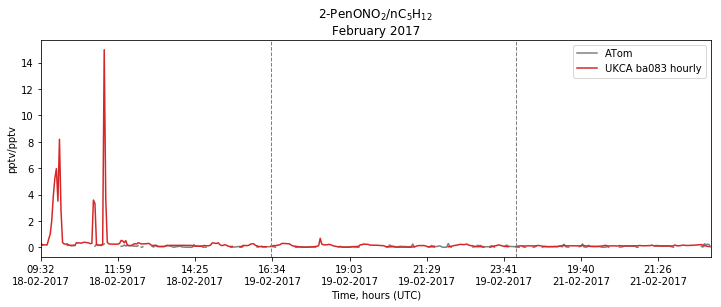

In [52]:
# Plot time series of RONO2/RH ratio along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['2-PenONO2_WAS']/atom_dswas['n-Pentane_WAS'], color='C7')
ax.plot(traj3d_cbr_n2peono2.data.squeeze()/traj3d_cbr_nc5h12.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_n2peono2}/{str_nc5h12}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C5nB.png', bbox_inches='tight')

In [ ]:
# Plot time series of RONO2/RH ratio along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['3-PenONO2_WAS']/atom_dswas['n-Pentane_WAS'], color='C7')
ax.plot(traj3d_cbr_n3peono2.data.squeeze()/traj3d_cbr_nc5h12.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_n3peono2}/{str_nc5h12}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C5nC.png', bbox_inches='tight')

In [ ]:
# Plot time series of RONO2/RH ratio along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['3-Methyl-2-BuONO2_WAS']/atom_dswas['i-Pentane_WAS'], color='C7')
ax.plot(traj3d_cbr_ipeono2.data.squeeze()/traj3d_cbr_ic5h12.data.squeeze(), color='C3')
# common
ax.set_title(f'{str_ipeono2}/{str_ic5h12}\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_ts_RONO2_RH_C5i.png', bbox_inches='tight')

#### Cross section along flight track

In [58]:
# Extract a cross section from model data along flight track (takes some time)
sample_time_lats_lons = [('t', sample_time), ('latitude', sample_lats), ('longitude', sample_lons)]
# traj2d_cbr_c2h6 = trajectory.interpolate(cbr_c2h6, sample_time_lats_lons)
# traj2d_cbr_c3h8 = trajectory.interpolate(cbr_c3h8, sample_time_lats_lons)
# traj2d_cbr_nc4h10 = trajectory.interpolate(cbr_nc4h10, sample_time_lats_lons)
# traj2d_cbr_ic4h10 = trajectory.interpolate(cbr_ic4h10, sample_time_lats_lons)
traj2d_cbr_nc5h12 = trajectory.interpolate(cbr_nc5h12, sample_time_lats_lons)
# traj2d_cbr_ic5h12 = trajectory.interpolate(cbr_ic5h12, sample_time_lats_lons)
# # traj2d_cbr_meono2 = trajectory.interpolate(cbr_meono2, sample_time_lats_lons)
# traj2d_cbr_sbuono2 = trajectory.interpolate(cbr_sbuono2, sample_time_lats_lons)
# traj2d_cbr_n2peono2 = trajectory.interpolate(cbr_n2peono2, sample_time_lats_lons)
# traj2d_cbr_n3peono2 = trajectory.interpolate(cbr_n3peono2, sample_time_lats_lons)
# traj2d_cbr_ipeono2 = trajectory.interpolate(cbr_ipeono2, sample_time_lats_lons)

In [17]:
# Convert xarray dataset with observational data to pandas dataframe
# atom_pdwas_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
# atom_pdwas_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_pdwas_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_pdwas_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_pdwas_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_pdwas_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
# # atom_pdwas_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_pdwas_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_pdwas_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_pdwas_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_pdwas_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [59]:
# Find max between maxima and max between minima in ATom and model cross section data for plotting a cross section with two colormaps
# cs_c2h6_max = max(np.nanmax(atom_pdwas_c2h6.values), np.nanmax(traj2d_cbr_c2h6.data*2))
# cs_c3h8_max = max(np.nanmax(atom_pdwas_c3h8.values), np.nanmax(traj2d_cbr_c3h8.data*3))
# cs_nc4h10_max = max(np.nanmax(atom_pdwas_nc4h10.values), np.nanmax(traj2d_cbr_nc4h10.data))
# cs_ic4h10_max = max(np.nanmax(atom_pdwas_ic4h10.values), np.nanmax(traj2d_cbr_ic4h10.data))
cs_nc5h12_max = max(np.nanmax(atom_pdwas_nc5h12.values), np.nanmax(traj2d_cbr_nc5h12.data))
# cs_ic5h12_max = max(np.nanmax(atom_pdwas_ic5h12.values), np.nanmax(traj2d_cbr_ic5h12.data))
# # cs_meono2_max = max(np.nanmax(atom_pdwas_meono2.values), np.nanmax(traj2d_cbr_meono2.data))
# cs_sbuono2_max = max(np.nanmax(atom_pdwas_sbuono2.values), np.nanmax(traj2d_cbr_sbuono2.data))
cs_n2peono2_max = max(np.nanmax(atom_pdwas_n2peono2.values), np.nanmax(traj2d_cbr_n2peono2.data))
# cs_n3peono2_max = max(np.nanmax(atom_pdwas_n3peono2.values), np.nanmax(traj2d_cbr_n3peono2.data))
# cs_ipeono2_max = max(np.nanmax(atom_pdwas_ipeono2.values), np.nanmax(traj2d_cbr_ipeono2.data))

# cs_c2h6_min = min(np.nanmax(atom_pdwas_c2h6.values), np.nanmax(traj2d_cbr_c2h6.data*2))
# cs_c3h8_min = min(np.nanmax(atom_pdwas_c3h8.values), np.nanmax(traj2d_cbr_c3h8.data*3))
# cs_nc4h10_min = min(np.nanmax(atom_pdwas_nc4h10.values), np.nanmax(traj2d_cbr_nc4h10.data))
# cs_ic4h10_min = min(np.nanmax(atom_pdwas_ic4h10.values), np.nanmax(traj2d_cbr_ic4h10.data))
cs_nc5h12_min = min(np.nanmax(atom_pdwas_nc5h12.values), np.nanmax(traj2d_cbr_nc5h12.data))
# cs_ic5h12_min = min(np.nanmax(atom_pdwas_ic5h12.values), np.nanmax(traj2d_cbr_ic5h12.data))
# # cs_meono2_min = min(np.nanmax(atom_pdwas_meono2.values), np.nanmax(traj2d_cbr_meono2.data))
# cs_sbuono2_min = min(np.nanmax(atom_pdwas_sbuono2.values), np.nanmax(traj2d_cbr_sbuono2.data))
cs_n2peono2_min = min(np.nanmax(atom_pdwas_n2peono2.values), np.nanmax(traj2d_cbr_n2peono2.data))
# cs_n3peono2_min = min(np.nanmax(atom_pdwas_n3peono2.values), np.nanmax(traj2d_cbr_n3peono2.data))
# cs_ipeono2_min = min(np.nanmax(atom_pdwas_ipeono2.values), np.nanmax(traj2d_cbr_ipeono2.data))

In [19]:
# Cross section plotting parameters
mrgd_time_inds = np.arange(0,atom_dsinf.time.values.shape[0],1) # merged time indices
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
# Merge two colormaps: color concentrations present in obs and model using one colormap and obs higher than model using another colormap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
colors_low = plt.cm.Blues(np.linspace(0,1,128))
colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
colors_stack = np.vstack((colors_low, colors_high))
mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)
cs_pc_kwargs = dict(cmap=mrgd_cmap, vmin=0) # model data pcolormesh options
cs_sc_kwargs = dict(cmap=mrgd_cmap, vmin=0, edgecolors='k', linewidth=0.2) # obs data scatter options

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_c2h6.coord('altitude').points, traj2d_cbr_c2h6.data.squeeze()*2, 
                   norm=MidpointNormalize(midpoint=cs_c2h6_min), vmax=cs_c2h6_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_c2h6.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_c2h6_min), vmax=cs_c2h6_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_c2h6}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C2.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_c3h8.coord('altitude').points, traj2d_cbr_c3h8.data.squeeze()*3, 
                   norm=MidpointNormalize(midpoint=cs_c3h8_min), vmax=cs_c3h8_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_c3h8.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_c3h8_min), vmax=cs_c3h8_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_c3h8}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C3.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_nc4h10.coord('altitude').points, traj2d_cbr_nc4h10.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_nc4h10_min), vmax=cs_nc4h10_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_nc4h10.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_nc4h10_min), vmax=cs_nc4h10_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_nc4h10}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C4n.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_ic4h10.coord('altitude').points, traj2d_cbr_ic4h10.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ic4h10_min), vmax=cs_ic4h10_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_ic4h10.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ic4h10_min), vmax=cs_ic4h10_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_ic4h10}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C4i.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


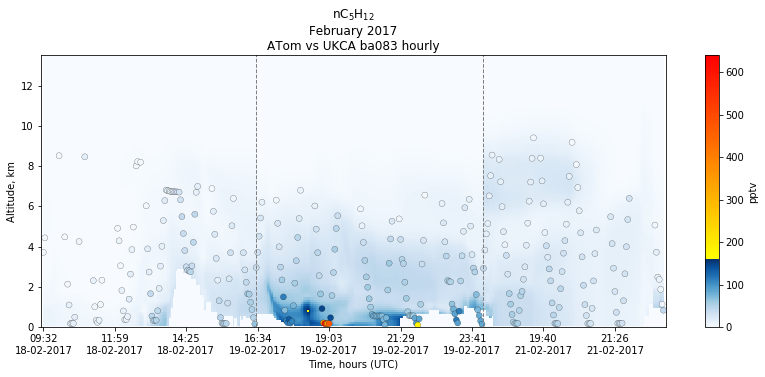

In [60]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_nc5h12.coord('altitude').points, traj2d_cbr_nc5h12.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_nc5h12_min), vmax=cs_nc5h12_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_nc5h12.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_nc5h12_min), vmax=cs_nc5h12_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_nc5h12}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C5n.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_ic5h12.coord('altitude').points, traj2d_cbr_ic5h12.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ic5h12_min), vmax=cs_ic5h12_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_ic5h12.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ic5h12_min), vmax=cs_ic5h12_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_ic5h12}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RH_C5i.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_meono2.coord('altitude').points, traj2d_cbr_meono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_meono2_min), vmax=cs_meono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_meono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_meono2_min), vmax=cs_meono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_meono2}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C1.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_sbuono2.coord('altitude').points, traj2d_cbr_sbuono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_sbuono2_min), vmax=cs_sbuono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_sbuono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_sbuono2_min), vmax=cs_sbuono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_sbuono2}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C4s.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


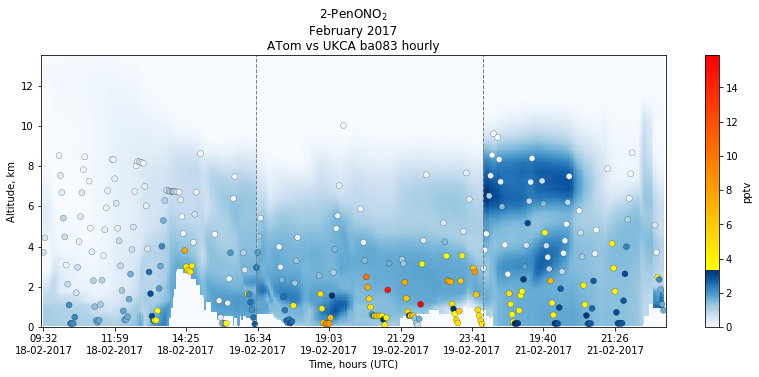

In [21]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_n2peono2.coord('altitude').points, traj2d_cbr_n2peono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_n2peono2_min), vmax=cs_n2peono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_n2peono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_n2peono2_min), vmax=cs_n2peono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_n2peono2}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C5nB.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_n3peono2.coord('altitude').points, traj2d_cbr_n3peono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_n3peono2_min), vmax=cs_n3peono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_n3peono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_n3peono2_min), vmax=cs_n3peono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_n3peono2}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C5nC.png', bbox_inches='tight')

In [ ]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, traj2d_cbr_ipeono2.coord('altitude').points, traj2d_cbr_ipeono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ipeono2_min), vmax=cs_ipeono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_pdwas_ipeono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ipeono2_min), vmax=cs_ipeono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_ipeono2}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_cs_RONO2_C5i.png', bbox_inches='tight')

#### Flight concentrations at all altitudes and model surface concentration (hybrid height level 0) 

In [61]:
# Add a cyclic point to model data for plotting it on a map
# cyclic_c2h6, cyclic_lons = cartopy.util.add_cyclic_point(cb_c2h6.data*2, coord=cb_c2h6.coord('longitude').points)
# cyclic_c3h8 = cartopy.util.add_cyclic_point(cb_c3h8.data*3)
# cyclic_nc4h10, cyclic_lons = cartopy.util.add_cyclic_point(cb_nc4h10.data, coord=cb_nc4h10.coord('longitude').points)
# cyclic_ic4h10 = cartopy.util.add_cyclic_point(cb_ic4h10.data)
cyclic_nc5h12, cyclic_lons = cartopy.util.add_cyclic_point(cb_nc5h12.data, coord=cb_nc5h12.coord('longitude').points)
# cyclic_ic5h12 = cartopy.util.add_cyclic_point(cb_ic5h12.data)
# cyclic_meono2 = cartopy.util.add_cyclic_point(cb_meono2.data)
# cyclic_sbuono2 = cartopy.util.add_cyclic_point(cb_sbuono2.data)
# cyclic_n2peono2, cyclic_lons = cartopy.util.add_cyclic_point(cb_n2peono2.data, coord=cb_n2peono2.coord('longitude').points)
# cyclic_n3peono2 = cartopy.util.add_cyclic_point(cb_n3peono2.data)
# cyclic_ipeono2 = cartopy.util.add_cyclic_point(cb_ipeono2.data)

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


In [62]:
# Select longitudes and latitudes where ATom data is available
# lons_c2h6_notnan = np.where(atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lons, atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2)
# lats_c2h6_notnan = np.where(atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lats, atom_pdwas_c2h6.Lumped_C2H6_C2H4_C2H2)
# lons_c3h8_notnan = np.where(atom_pdwas_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lons, atom_pdwas_c3h8.Lumped_C3H8_C3H6)
# lats_c3h8_notnan = np.where(atom_pdwas_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lats, atom_pdwas_c3h8.Lumped_C3H8_C3H6)
# lons_nc4h10_notnan = np.where(atom_pdwas_nc4h10['n-Butane_WAS'].isna()==False, sample_lons, atom_pdwas_nc4h10['n-Butane_WAS'])
# lats_nc4h10_notnan = np.where(atom_pdwas_nc4h10['n-Butane_WAS'].isna()==False, sample_lats, atom_pdwas_nc4h10['n-Butane_WAS'])
# lons_ic4h10_notnan = np.where(atom_pdwas_ic4h10['i-Butane_WAS'].isna()==False, sample_lons, atom_pdwas_ic4h10['i-Butane_WAS'])
# lats_ic4h10_notnan = np.where(atom_pdwas_ic4h10['i-Butane_WAS'].isna()==False, sample_lats, atom_pdwas_ic4h10['i-Butane_WAS'])
lons_nc5h12_notnan = np.where(atom_pdwas_nc5h12['n-Pentane_WAS'].isna()==False, sample_lons, atom_pdwas_nc5h12['n-Pentane_WAS'])
lats_nc5h12_notnan = np.where(atom_pdwas_nc5h12['n-Pentane_WAS'].isna()==False, sample_lats, atom_pdwas_nc5h12['n-Pentane_WAS'])
# lons_ic5h12_notnan = np.where(atom_pdwas_ic5h12['i-Pentane_WAS'].isna()==False, sample_lons, atom_pdwas_ic5h12['i-Pentane_WAS'])
# lats_ic5h12_notnan = np.where(atom_pdwas_ic5h12['i-Pentane_WAS'].isna()==False, sample_lats, atom_pdwas_ic5h12['i-Pentane_WAS'])
# lons_meono2_notnan = np.where(atom_pdwas_meono2['MeONO2_WAS'].isna()==False, sample_lons, atom_pdwas_meono2['MeONO2_WAS'])
# lats_meono2_notnan = np.where(atom_pdwas_meono2['MeONO2_WAS'].isna()==False, sample_lats, atom_pdwas_meono2['MeONO2_WAS'])
# lons_sbuono2_notnan = np.where(atom_pdwas_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lons, atom_pdwas_sbuono2['2-BuONO2_WAS'])
# lats_sbuono2_notnan = np.where(atom_pdwas_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lats, atom_pdwas_sbuono2['2-BuONO2_WAS'])
lons_n2peono2_notnan = np.where(atom_pdwas_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lons, atom_pdwas_n2peono2['2-PenONO2_WAS'])
lats_n2peono2_notnan = np.where(atom_pdwas_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lats, atom_pdwas_n2peono2['2-PenONO2_WAS'])
# lons_n3peono2_notnan = np.where(atom_pdwas_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lons, atom_pdwas_n3peono2['3-PenONO2_WAS'])
# lats_n3peono2_notnan = np.where(atom_pdwas_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lats, atom_pdwas_n3peono2['3-PenONO2_WAS'])
# lons_ipeono2_notnan = np.where(atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lons, atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'])
# lats_ipeono2_notnan = np.where(atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lats, atom_pdwas_ipeono2['3-Methyl-2-BuONO2_WAS'])

In [63]:
# Find max surface concentration in model data
# mpglb_c2h6_max = int(cyclic_c2h6[0,0,...].max())
# mpglb_c3h8_max = int(cyclic_c3h8[0,0,...].max())
# mpglb_nc4h10_max = int(cyclic_nc4h10[0,0,...].max())
# mpglb_ic4h10_max = int(cyclic_ic4h10[0,0,...].max())
mpglb_nc5h12_max = int(cyclic_nc5h12[0,0,...].max())
# mpglb_ic5h12_max = int(cyclic_ic5h12[0,0,...].max())
# mpglb_meono2_max = int(cyclic_meono2[0,0,...].max())
# mpglb_sbuono2_max = int(cyclic_sbuono2[0,0,...].max())
mpglb_n2peono2_max = int(cyclic_n2peono2[0,0,...].max())
# mpglb_n3peono2_max = int(cyclic_n3peono2[0,0,...].max())
# mpglb_ipeono2_max = int(cyclic_ipeono2[0,0,...].max())
print(atom_ukca_datetime_match)
# print(f'C2H6: {mpglb_c2h6_max}')
# print(f'C3H8: {mpglb_c3h8_max}')
# print(f'nC4H10: {mpglb_nc4h10_max}')
# print(f'iC4H10: {mpglb_ic4h10_max}')
print(f'nC5H12: {mpglb_nc5h12_max}')
# print(f'iC5H12: {mpglb_ic5h12_max}')
# print(f'MeONO2: {mpglb_meono2_max}')
# print(f'2-BuONO2: {mpglb_sbuono2_max}')
print(f'2-PenONO2: {mpglb_n2peono2_max}')
# print(f'3-PenONO2: {mpglb_n3peono2_max}')
# print(f'3-Methyl-2-BuONO2: {mpglb_ipeono2_max}')

170218_170221_1702_merge
nC5H12: 748
2-PenONO2: 8


In [64]:
# Choose a range that allows to display the variability in lower concentrations
mpglb_c2h6_range = np.arange(0,11000,1000)
mpglb_c3h8_range = np.arange(0,4500,500)
mpglb_nc4h10_range = np.arange(0,450,50)
mpglb_ic4h10_range = np.arange(0,220,20)
mpglb_nc5h12_range = np.arange(0,220,20)
mpglb_ic5h12_range = np.arange(0,220,20)
mpglb_meono2_range = np.arange(0,50,5)
mpglb_sbuono2_range = np.arange(0,11,1)
mpglb_n2peono2_range = np.arange(0,5.5,0.5)
mpglb_n3peono2_range = np.arange(0,5.5,0.5)
mpglb_ipeono2_range = np.arange(0,5.5,0.5)

In [65]:
# Global map plotting parameters
mp_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Oranges', extend='max')
mp_sc_kwargs = dict(transform=ccrs.PlateCarree(), c='C0', edgecolors='k', linewidth=0.2)
mp_arrow_kwargs = dict(transform=ccrs.PlateCarree(), color='C0', width=3)
# Add locations where ATom fligths stopped and arrows to show flights general direction
if atom_ukca_datetime_match == '170218_170221_1702_merge':
    atom_stops = [dict(name='Palmdale', lon=-118.100556, lat=34.581111),
                  dict(name='Anchorage', lon=-149.9, lat=61.216667),
                  dict(name='Kona', lon=-155.994167, lat=19.65),
                  dict(name='Azores', lon=-25.675556, lat=37.741111),
                  dict(name='Thule', lon=-69.230556, lat=77.466667)]
    mp_arrows = [dict(name='North Atlantic', x=-40, y=20, dx=-5, dy=25)] 
# elif atom_ukca_datetime_match == '170126_170130_1701_merge':
#     atom_stops = [dict(name='Palmdale', lon=-118.100556, lat=34.581111),
#                   dict(name='Equator', lon=-120, lat=0),
#                   dict(name='Anchorage', lon=-149.9, lat=61.216667)]
#     mp_arrows = [dict(name='Palmdale-Equator', x=-130, y=32, dx=0, dy=-20),
#                  dict(name='Equator-Palmdale', x=-110, y=8, dx=0, dy=10),
#                  dict(name='Palmdale-Anchorage-ocean', x=-145, y=35, dx=-8, dy=15)]
# elif atom_ukca_datetime_match == '170201_170221_1702_merge':
#     atom_stops = [dict(name='Anchorage', lon=-149.9, lat=61.216667),
#                   dict(name='Kona', lon=-155.994167, lat=19.65),
#                   dict(name='Nadi', lon=177.416667, lat=-17.8),
#                   dict(name='Christchurch', lon=172.620278, lat=-43.53),
#                   dict(name='Punta Arenas', lon=-70.933333, lat=-53.166667),
#                   dict(name='Ascension', lon=-14.366667, lat=-7.933333),
#                   dict(name='Azores', lon=-25.675556, lat=37.741111),
#                   dict(name='Thule', lon=-69.230556, lat=77.466667),
#                   dict(name='Palmdale', lon=-118.100556, lat=34.581111)]
#     mp_arrows = [dict(name='North Pacific', x=-170, y=50, dx=-15, dy=-30),
#                  dict(name='South Pacific', x=210, y=-50, dx=50, dy=0),
#                  dict(name='North Atlantic', x=-40, y=20, dx=-5, dy=25),
#                  dict(name='North America', x=-130, y=60, dx=10, dy=-10)]
ukca_mp_utc_ind = 425
ukca_datetime_mp_utc = ukca_datetime[ukca_mp_utc_ind].strftime("%d %B %Y %H:%M UTC")

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_c2h6.coord('latitude').points, cyclic_c2h6[0,0,...], levels=mpglb_c2h6_range, **mp_cf_kwargs)
ax.scatter(lons_c2h6_notnan, lats_c2h6_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_c2h6}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptvC', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_c2h6_max} pptvC')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C2.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_c3h8.coord('latitude').points, cyclic_c3h8[0,0,...], levels=mpglb_c3h8_range, **mp_cf_kwargs)
ax.scatter(lons_c3h8_notnan, lats_c3h8_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_c3h8}\n{atom_date_start.strftime("%B %Y")}\nATom vs UKCA {ukca_run_name} montly mean')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptvC', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_c3h8_max} pptvC')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mpglb_RH_C3.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_nc4h10.coord('latitude').points, cyclic_nc4h10[ukca_mp_utc_ind,0,...], levels=mpglb_nc4h10_range, **mp_cf_kwargs)
ax.scatter(lons_nc4h10_notnan, lats_nc4h10_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_title(f'{str_nc4h10}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_nc4h10_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
# for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RH_C4n.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_ic4h10.coord('latitude').points, cyclic_ic4h10[ukca_mp_utc_ind,0,...], levels=mpglb_ic4h10_range, **mp_cf_kwargs)
ax.scatter(lons_ic4h10_notnan, lats_ic4h10_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_ic4h10}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_ic4h10_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RH_C4i.png', bbox_inches='tight')

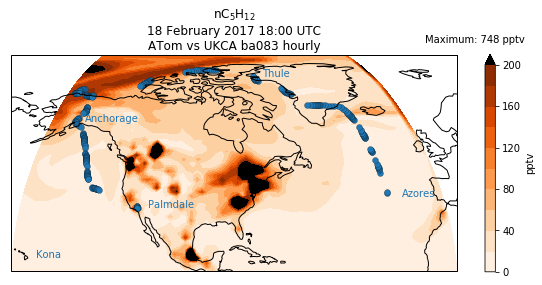

In [67]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_nc5h12.coord('latitude').points, cyclic_nc5h12[ukca_mp_utc_ind,0,...], levels=mpglb_nc5h12_range, **mp_cf_kwargs)
ax.scatter(lons_nc5h12_notnan, lats_nc5h12_notnan, **mp_sc_kwargs)
ax.coastlines()
# ax.set_global()
ax.set_title(f'{str_nc5h12}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_nc5h12_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
# for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RH_C5n.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_ic5h12.coord('latitude').points, cyclic_ic5h12[ukca_mp_utc_ind,0,...], levels=mpglb_ic5h12_range, **mp_cf_kwargs)
ax.scatter(lons_ic5h12_notnan, lats_ic5h12_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_ic5h12}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_ic5h12_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RH_C5i.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_meono2.coord('latitude').points, cyclic_meono2[ukca_mp_utc_ind,0,...], levels=mpglb_meono2_range, **mp_cf_kwargs)
ax.scatter(lons_meono2_notnan, lats_meono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_meono2}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_meono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RONO2_C1.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_sbuono2.coord('latitude').points, cyclic_sbuono2[ukca_mp_utc_ind,0,...], levels=mpglb_sbuono2_range, **mp_cf_kwargs)
ax.scatter(lons_sbuono2_notnan, lats_sbuono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_title(f'{str_sbuono2}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_sbuono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
# for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RONO2_C4s.png', bbox_inches='tight')

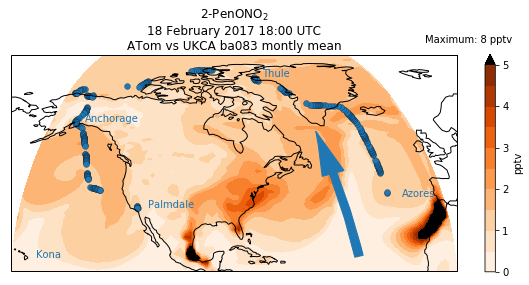

In [29]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_n2peono2.coord('latitude').points, cyclic_n2peono2[ukca_mp_utc_ind,0,...], levels=mpglb_n2peono2_range, **mp_cf_kwargs)
ax.scatter(lons_n2peono2_notnan, lats_n2peono2_notnan, **mp_sc_kwargs)
ax.coastlines()
# ax.set_global()
ax.set_title(f'{str_n2peono2}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_n2peono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RONO2_C5nB.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_n3peono2.coord('latitude').points, cyclic_n3peono2[ukca_mp_utc_ind,0,...], levels=mpglb_n3peono2_range, **mp_cf_kwargs)
ax.scatter(lons_n3peono2_notnan, lats_n3peono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_n3peono2}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_n3peono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RONO2_C5nC.png', bbox_inches='tight')

In [ ]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cbr_ipeono2.coord('latitude').points, cyclic_ipeono2[ukca_mp_utc_ind,0,...], levels=mpglb_ipeono2_range, **mp_cf_kwargs)
ax.scatter(lons_ipeono2_notnan, lats_ipeono2_notnan, **mp_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_ipeono2}\n{ukca_datetime_mp_utc}\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('k')
fig.colorbar(p1, shrink=0.4, label='pptv', extend='max')
fig.text(0.7, 0.67, f'Maximum: {mpglb_ipeono2_max} pptv')
for i in atom_stops: ax.text(i['lon']+4, i['lat'], i['name'], transform=ccrs.PlateCarree(), color='C0')
for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_mploc_RONO2_C5i.png', bbox_inches='tight')

#### Plot all flight track data as a scatter plot

In [55]:
# Find max concentration between observational and model trajectory data
# sct_max_c2h6 = max(np.nanmax(atom_pdwas_c2h6.values), np.nanmax(traj3d_cbr_c2h6.data*2))
# sct_max_c3h8 = max(np.nanmax(atom_pdwas_c3h8.values), np.nanmax(traj3d_cbr_c3h8.data*3))
# sct_max_nc4h10 = max(np.nanmax(atom_pdwas_nc4h10.values), np.nanmax(traj3d_cbr_nc4h10.data))
# sct_max_ic4h10 = max(np.nanmax(atom_pdwas_ic4h10.values), np.nanmax(traj3d_cbr_ic4h10.data))
sct_max_nc5h12 = max(np.nanmax(atom_pdwas_nc5h12.values), np.nanmax(traj3d_cbr_nc5h12.data))
# sct_max_ic5h12 = max(np.nanmax(atom_pdwas_ic5h12.values), np.nanmax(traj3d_cbr_ic5h12.data))
# # sct_max_meono2 = max(np.nanmax(atom_pdwas_meono2.values), np.nanmax(traj3d_cbr_meono2.data))
# sct_max_sbuono2 = max(np.nanmax(atom_pdwas_sbuono2.values), np.nanmax(traj3d_cbr_sbuono2.data))
sct_max_n2peono2 = max(np.nanmax(atom_pdwas_n2peono2.values), np.nanmax(traj3d_cbr_n2peono2.data))
# sct_max_n3peono2 = max(np.nanmax(atom_pdwas_n3peono2.values), np.nanmax(traj3d_cbr_n3peono2.data))
# sct_max_ipeono2 = max(np.nanmax(atom_pdwas_ipeono2.values), np.nanmax(traj3d_cbr_ipeono2.data))

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_c2h6.squeeze(), traj3d_cbr_c2h6.data.squeeze()*2, c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_c2h6+1], [0, sct_max_c2h6+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_c2h6}, pptvC\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_c2h6+1)
ax.set_ylim(0, sct_max_c2h6+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C2.png', bbox_inches='tight')

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_c3h8.squeeze(), traj3d_cbr_c3h8.data.squeeze()*3, c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_c3h8+1], [0, sct_max_c3h8+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_c3h8}, pptvC\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
ax.set_xlim(0, sct_max_c3h8+1)
ax.set_ylim(0, sct_max_c3h8+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C3.png', bbox_inches='tight')

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_nc4h10.squeeze(), traj3d_cbr_nc4h10.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_nc4h10+1], [0, sct_max_nc4h10+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_nc4h10}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_nc4h10+1)
ax.set_ylim(0, sct_max_nc4h10+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C4n.png', bbox_inches='tight')

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_ic4h10.squeeze(), traj3d_cbr_ic4h10.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ic4h10+1], [0, sct_max_ic4h10+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ic4h10}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_ic4h10+1)
ax.set_ylim(0, sct_max_ic4h10+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C4i.png', bbox_inches='tight')

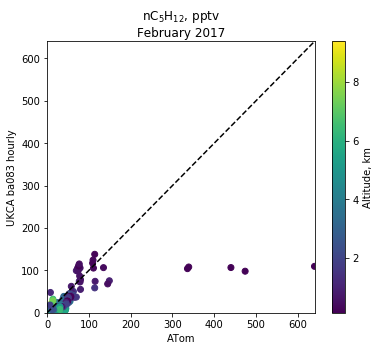

In [57]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_nc5h12.squeeze(), traj3d_cbr_nc5h12.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_nc5h12+1], [0, sct_max_nc5h12+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_nc5h12}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_nc5h12+1)
ax.set_ylim(0, sct_max_nc5h12+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C5n.png', bbox_inches='tight')

In [33]:
def calc_regression(x, y):
    # Remove NaN from arrays
    x_nonan = []; y_nonan = []
    for i, j in zip(x, y):
        if np.isnan(i) or np.isnan(j):
            pass
        else:
            x_nonan.append(i)
            y_nonan.append(j)
    # Calculate a linear least-squares regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_nonan, y_nonan)
    # Create a regression model
    regression = []
    for i in x_nonan:
        regression.append(slope*i + intercept)
    return x_nonan, regression, r_value
# delta = traj3d_cbr_nc5h12.data.squeeze() - atom_pdwas_nc5h12.squeeze()
# delta.dropna().mean(), delta.dropna().std()

In [34]:
# nc5h12_rgrss_x, nc5h12_rgrss_y, nc5h12_rgrss_r_value = calc_regression(atom_pdwas_nc5h12.squeeze().values, traj3d_cbr_nc5h12.data.squeeze())
n2peono2_rgrss_x, n2peono2_rgrss_y, n2peono2_rgrss_r_value = calc_regression(atom_pdwas_n2peono2.squeeze().values, traj3d_cbr_n2peono2.data.squeeze())

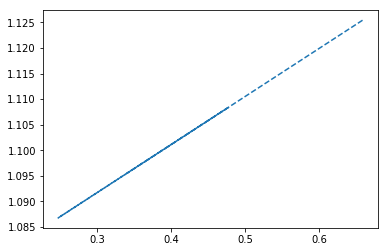

In [41]:
plt.plot(n2peono2_rgrss_x[0:5], n2peono2_rgrss_y[0:5], linestyle='--');
plt.savefig('fig.png', facecolor='w')

In [53]:
delta = traj3d_cbr_nc5h12.data.squeeze() - atom_pdwas_nc5h12.squeeze()
delta.dropna().describe()

count    273.000000
mean     -16.339545
std       48.995259
min     -530.436455
25%      -18.621292
50%      -12.314857
75%       -3.885997
max       39.984413
Name: n-Pentane_WAS, dtype: float64

In [71]:
def remove_nans(x, y):
    # Remove NaN from arrays
    x_nonan = []; y_nonan = []
    for i, j in zip(x, y):
        if np.isnan(i) or np.isnan(j):
            pass
        else:
            x_nonan.append(i)
            y_nonan.append(j)
    return x_nonan, y_nonan

In [76]:
np.corrcoef(remove_nans(atom_pdwas_nc5h12.squeeze().values, traj3d_cbr_nc5h12.data.squeeze()))

array([[1.        , 0.65967266],
       [0.65967266, 1.        ]])

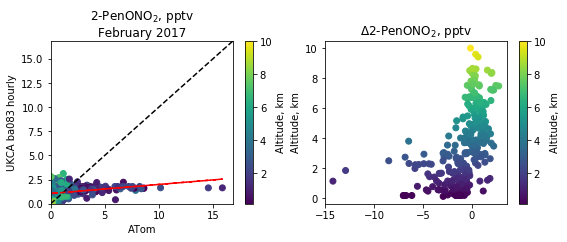

In [37]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3), facecolor='w')
p0 = ax[0].scatter(atom_pdwas_n2peono2.squeeze(), traj3d_cbr_n2peono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax[0].plot([0, sct_max_n2peono2+1], [0, sct_max_n2peono2+1], color='k', linestyle='--') # 'one-to-one' line
ax[0].plot(n2peono2_rgrss_x, n2peono2_rgrss_y, color='r', linestyle='--');
# ax[0].text(400, 200, f'$R^2=${n2peono2_rgrss_r_value**2:1.2f}', color='r')
ax[0].set_title(f'{str_n2peono2}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax[0].set_xlabel('ATom')
ax[0].set_ylabel(f'UKCA {ukca_run_name} hourly')
ax[0].set_xlim(0, sct_max_n2peono2+1)
ax[0].set_ylim(0, sct_max_n2peono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km), ax=ax[0])
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C5n.png', bbox_inches='tight')

p1 = ax[1].scatter(traj3d_cbr_n2peono2.data.squeeze() - atom_pdwas_n2peono2.squeeze(), atom_dsmms.G_ALT, c=atom_dsmms.G_ALT);
ax[1].set_title(f'$\Delta${str_n2peono2}, pptv')
ax[1].set_ylabel('Altitude, km')
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(m2km))
fig.colorbar(p1, label='Altitude, km', format=FuncFormatter(m2km), ax=ax[1]);
# p2 = ax[2].scatter(atom_pdwas_n2peono2.squeeze()[atom_dsmms.G_ALT>2000], traj3d_cbr_n2peono2.data.squeeze()[atom_dsmms.G_ALT>2000], c=atom_dsmms.G_ALT[atom_dsmms.G_ALT>2000], cmap='inferno')
# ax[2].set_title('Above 2 km')
# ax[2].set_xlabel('ATom')
# ax[2].set_ylabel(f'UKCA {ukca_run_name} hourly')
# fig.colorbar(p2, label='Altitude, km', format=FuncFormatter(m2km), ax=ax[2]);

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3), facecolor='w')
p0 = ax[0].scatter(atom_pdwas_nc5h12.squeeze(), traj3d_cbr_nc5h12.data.squeeze(), c=atom_dsmms.G_ALT)
ax[0].plot([0, sct_max_nc5h12+1], [0, sct_max_nc5h12+1], color='k', linestyle='--') # 'one-to-one' line
ax[0].plot(nc5h12_rgrss_x, nc5h12_rgrss_y, color='r', linestyle='--');
ax[0].text(400, 200, f'$R^2=${nc5h12_rgrss_r_value**2:1.2f}', color='r')
ax[0].set_title(f'{str_nc5h12}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax[0].set_xlabel('ATom')
ax[0].set_ylabel(f'UKCA {ukca_run_name} hourly')
ax[0].set_xlim(0, sct_max_nc5h12+1)
ax[0].set_ylim(0, sct_max_nc5h12+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km), ax=ax[0])
# if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C5n.png', bbox_inches='tight')

p1 = ax[1].scatter(traj3d_cbr_nc5h12.data.squeeze() - atom_pdwas_nc5h12.squeeze(), atom_dsmms.G_ALT, c=atom_dsmms.G_ALT);
ax[1].set_title(f'$\Delta${str_nc5h12}, pptv')
ax[1].set_ylabel('Altitude, km')
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(m2km))
fig.colorbar(p1, label='Altitude, km', format=FuncFormatter(m2km), ax=ax[1])
# p2 = ax[2].scatter(atom_pdwas_nc5h12.squeeze()[atom_dsmms.G_ALT>2000], traj3d_cbr_nc5h12.data.squeeze()[atom_dsmms.G_ALT>2000], c=atom_dsmms.G_ALT[atom_dsmms.G_ALT>2000], cmap='inferno')
# ax[2].set_title('Above 2 km')
# ax[2].set_xlabel('ATom')
# ax[2].set_ylabel(f'UKCA {ukca_run_name} hourly')
# fig.colorbar(p2, label='Altitude, km', format=FuncFormatter(m2km), ax=ax[2]);

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_ic5h12.squeeze(), traj3d_cbr_ic5h12.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ic5h12+1], [0, sct_max_ic5h12+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ic5h12}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_ic5h12+1)
ax.set_ylim(0, sct_max_ic5h12+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RH_C5i.png', bbox_inches='tight')

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_meono2.squeeze(), traj3d_cbr_meono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_meono2+1], [0, sct_max_meono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_meono2}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_meono2+1)
ax.set_ylim(0, sct_max_meono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C1.png', bbox_inches='tight')

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_sbuono2.squeeze(), traj3d_cbr_sbuono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_sbuono2+1], [0, sct_max_sbuono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_sbuono2}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_sbuono2+1)
ax.set_ylim(0, sct_max_sbuono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C4s.png', bbox_inches='tight')

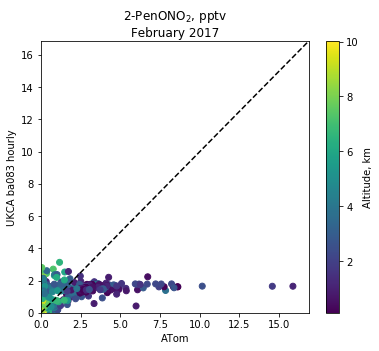

In [32]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_n2peono2.squeeze(), traj3d_cbr_n2peono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_n2peono2+1], [0, sct_max_n2peono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_n2peono2}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_n2peono2+1)
ax.set_ylim(0, sct_max_n2peono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C5nB.png', bbox_inches='tight')

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_n3peono2.squeeze(), traj3d_cbr_n3peono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_n3peono2+1], [0, sct_max_n3peono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_n3peono2}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_n3peono2+1)
ax.set_ylim(0, sct_max_n3peono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C5nC.png', bbox_inches='tight')

In [ ]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_pdwas_ipeono2.squeeze(), traj3d_cbr_ipeono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ipeono2+1], [0, sct_max_ipeono2+1], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ipeono2}, pptv\n{atom_date_start.strftime("%B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0, sct_max_ipeono2+1)
ax.set_ylim(0, sct_max_ipeono2+1)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_1to1_RONO2_C5i.png', bbox_inches='tight')

In [ ]:
break

#### RONO2/RH surface map

In [ ]:
l = 0
c4s_srf_ratio = cyclic_sbuono2[0,l,...]/cyclic_nc4h10[0,l,...]
c5nB_srf_ratio = cyclic_n2peono2[0,l,...]/cyclic_nc5h12[0,l,...]
c5nC_srf_ratio = cyclic_n3peono2[0,l,...]/cyclic_nc5h12[0,l,...]
c5i_srf_ratio = cyclic_ipeono2[0,l,...]/cyclic_ic5h12[0,l,...]

In [ ]:
np.nanmax(c4s_srf_ratio), np.nanmax(c5nB_srf_ratio), np.nanmax(c5nC_srf_ratio), np.nanmax(c5i_srf_ratio)

In [ ]:
np.unravel_index(c4s_srf_ratio.argmax(), c4s_srf_ratio.shape), np.unravel_index(c5nB_srf_ratio.argmax(), c5nB_srf_ratio.shape), \
np.unravel_index(c5nC_srf_ratio.argmax(), c5nC_srf_ratio.shape), np.unravel_index(c5i_srf_ratio.argmax(), c5i_srf_ratio.shape)

In [ ]:
c5nB_srf_ratio.max(), c5nB_srf_ratio[63, 146]

In [ ]:
cb_nc4h10.coord('latitude').points[63]

In [ ]:
cb_nc4h10.coord('longitude').points[146]

In [ ]:
cb_sbuono2[0,l,63,146].data*coeff_sbuono2, cb_nc4h10[0,l,63,146].data*coeff_nc4h10

In [ ]:
0.018749696514433086/0.002512471780707066

In [ ]:
sorted(c4s_srf_ratio.flatten())[-2], sorted(c5nB_srf_ratio.flatten())[-2], \
sorted(c5nC_srf_ratio.flatten())[-2], sorted(c5i_srf_ratio.flatten())[-2]

In [ ]:
class MidpointNormalize2(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [ ]:
ratio_map_kwargs = dict(transform=ccrs.PlateCarree(), cmap='coolwarm')
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,8), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p00 = axes[0,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, c4s_srf_ratio, norm=MidpointNormalize2(midpoint=1., vmin=0, vmax=sorted(c4s_srf_ratio.flatten())[-2]), **ratio_map_kwargs);
p01 = axes[0,1].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, c5nB_srf_ratio, norm=MidpointNormalize2(midpoint=1., vmin=0, vmax=sorted(c5nB_srf_ratio.flatten())[-2]), **ratio_map_kwargs);
p10 = axes[1,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, c5i_srf_ratio, norm=MidpointNormalize2(midpoint=1., vmin=0, vmax=sorted(c5i_srf_ratio.flatten())[-2]), **ratio_map_kwargs);
p11 = axes[1,1].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, c5nC_srf_ratio, norm=MidpointNormalize2(midpoint=1., vmin=0, vmax=sorted(c5nC_srf_ratio.flatten())[-2]), **ratio_map_kwargs);
axes[0,0].set_title(f'{str_sbuono2}/{str_nc4h10}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[0,1].set_title(f'{str_n2peono2}/{str_nc5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[1,0].set_title(f'{str_ipeono2}/{str_ic5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[1,1].set_title(f'{str_n3peono2}/{str_nc5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
for ax in axes.flatten():
    ax.coastlines();
    ax.set_global();
cb00 = fig.colorbar(p00, ax=axes[0,0], shrink=0.9);
cb01 = fig.colorbar(p01, ax=axes[0,1], shrink=0.9);
cb10 = fig.colorbar(p10, ax=axes[1,0], shrink=0.9);
cb11 = fig.colorbar(p11, ax=axes[1,1], shrink=0.9);
fig.subplots_adjust(wspace=-0.2);
fig.tight_layout();
fig.savefig('srf_ratio_maps_january.png')

In [ ]:
ratio_map_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Blues')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,8), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p00 = axes[0,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_nc4h10[0,0,...], vmin=0, vmax=100, **ratio_map_kwargs);
p01 = axes[0,1].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_nc5h12[0,0,...], vmin=0, vmax=100, **ratio_map_kwargs);
p10 = axes[1,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_ic5h12[0,0,...], vmin=0, vmax=100, **ratio_map_kwargs);
axes[0,0].set_title(f'{str_sbuono2}/{str_nc4h10}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[0,1].set_title(f'{str_n2peono2}/{str_nc5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[1,0].set_title(f'{str_ipeono2}/{str_ic5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
for ax in axes.flatten()[0:3]:
    ax.coastlines();
    ax.set_global();
cb00 = fig.colorbar(p00, ax=axes[0,0], shrink=0.9, extend='max');
cb01 = fig.colorbar(p01, ax=axes[0,1], shrink=0.9, extend='max');
cb10 = fig.colorbar(p10, ax=axes[1,0], shrink=0.9, extend='max');
fig.subplots_adjust(wspace=-0.2);
fig.tight_layout();
# fig.savefig('srf_ratio_maps_january.png')

In [ ]:
ratio_map_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Blues')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,8), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p00 = axes[0,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_sbuono2[0,0,...], vmin=0, vmax=2, **ratio_map_kwargs);
p01 = axes[0,1].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_n2peono2[0,0,...], vmin=0, vmax=2, **ratio_map_kwargs);
p10 = axes[1,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_ipeono2[0,0,...], vmin=0, vmax=2, **ratio_map_kwargs);
p11 = axes[1,1].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_n3peono2[0,0,...], vmin=0, vmax=2, **ratio_map_kwargs);
axes[0,0].set_title(f'{str_sbuono2}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[0,1].set_title(f'{str_n2peono2}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[1,0].set_title(f'{str_ipeono2}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
axes[1,1].set_title(f'{str_n3peono2}\n{ukca_date.strftime("%B %Y")} (mean) surface', fontsize=10);
for ax in axes.flatten():
    ax.coastlines();
    ax.set_global();
cb00 = fig.colorbar(p00, ax=axes[0,0], shrink=0.9, label='pptv', extend='max');
cb01 = fig.colorbar(p01, ax=axes[0,1], shrink=0.9, label='pptv', extend='max');
cb10 = fig.colorbar(p10, ax=axes[1,0], shrink=0.9, label='pptv', extend='max');
cb11 = fig.colorbar(p11, ax=axes[1,1], shrink=0.9, label='pptv', extend='max');
fig.subplots_adjust(wspace=-0.2);
fig.tight_layout();
# fig.savefig('srf_ratio_maps_january.png')

In [ ]:
prssr = iris.load_cube(str(path_to_ukca_run / fname_ukca_run), 'air_pressure_at_sea_level')

In [ ]:
cyclic_prssr = cartopy.util.add_cyclic_point(prssr.data/100)

In [ ]:
cyclic_prssr.min(), cyclic_prssr.max()

In [ ]:
np.arange(980, 1044, 4)

In [ ]:
ratio_map1_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Blues')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), subplot_kw=dict(projection=ccrs.Stereographic(central_latitude=90, central_longitude=-40.0)), facecolor='w')
CS = axes[0,0].contour(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_prssr[0,0,...], levels=np.arange(980, 1044, 4), cmap='gray_r', transform=ccrs.PlateCarree())#, norm=MidpointNormalize(midpoint=1004))
# plt.clabel(CS, CS.levels, inline=1, fontsize=10)

p00 = axes[0,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_sbuono2[0,0,...]/cyclic_nc4h10[0,0,...], vmin=0, vmax=0.1, **ratio_map1_kwargs)
p01 = axes[0,1].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_n2peono2[0,0,...]/cyclic_nc5h12[0,0,...], vmin=0, vmax=0.1, **ratio_map1_kwargs)
p10 = axes[1,0].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_ipeono2[0,0,...]/cyclic_ic5h12[0,0,...], vmin=0, vmax=0.1, **ratio_map1_kwargs)
p11 = axes[1,1].pcolormesh(cyclic_lons, cb_nc4h10.coord('latitude').points, cyclic_n3peono2[0,0,...]/cyclic_nc5h12[0,0,...], vmin=0, vmax=0.1, **ratio_map1_kwargs)

fig.colorbar(p00, ax=axes[0,0], shrink=0.7, label='pptv/pptv', extend='max')
fig.colorbar(p01, ax=axes[0,1], shrink=0.7, label='pptv/pptv', extend='max')
fig.colorbar(p10, ax=axes[1,0], shrink=0.7, label='pptv/pptv', extend='max')
fig.colorbar(p11, ax=axes[1,1], shrink=0.7, label='pptv/pptv', extend='max')
axes[0,0].set_title(f'{str_sbuono2}/{str_nc4h10}\n{ukca_date.strftime("%B %Y")} (mean) surface + SLP (hPa)');
axes[0,1].set_title(f'{str_n2peono2}/{str_nc5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface');
axes[1,0].set_title(f'{str_ipeono2}/{str_ic5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface');
axes[1,1].set_title(f'{str_n3peono2}/{str_nc5h12}\n{ukca_date.strftime("%B %Y")} (mean) surface');
# common
for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent([0, 359, 0, 90], crs=ccrs.PlateCarree());
    
# axcb = fig.add_axes() # [0.3, 0.1, 0.5, 0.01]
# fig.colorbar(CS, ax=axcb, orientation='horizontal')
fig.subplots_adjust(wspace=-0.4);
fig.tight_layout();
# fig.savefig('rono2_rh_ratio_nh_jan.png')

In [ ]:
# # with normalization
# # Plot flight data at all altitudes and model surface concentration (hybrid height level 0)
# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
# ax.contourf(cyclic_lons, cbr_meono2.coord('latitude').points, cyclic_meono2[0,0,...], levels=bounds_meono2, **mp_cf_kwargs);
# p1 = ax.scatter(sample_lons, sample_lats, c=atom_pdwas_meono2.squeeze(), norm=norm_meono2, **mp_sc_kwargs);
# ax.coastlines();
# ax.set_global();
# ax.set_title(f'{str_meono2}\nATom '+atom_date_start.strftime('%d %B %Y')+'\nUKCA ax631a '+ukca_date.strftime('%B %Y')+' (mean) surface');
# fig.colorbar(p1, shrink=0.4, label='pptv');

In [ ]:
# # Add a cyclic point to releveled model data for plotting a map
# cycl_rlvl_meono2, cclc_lons = cartopy.util.add_cyclic_point(cbr_meono2.data*coeff_meono2, coord=cbr_meono2.coord('longitude').points)
# # Choose altitude
# alt = 4

In [ ]:
# # Plot flight data at all altitudes and releveled model data at a chosen altitude
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
# ax.contourf(cclc_lons, cbr_meono2.coord('latitude').points, cycl_rlvl_meono2[0,alt,...],
#             transform=ccrs.PlateCarree(), levels=bounds_meono2, cmap='Oranges');
# p1 = ax.scatter(sample_lons, sample_lats, c=atom_pdwas_meono2.MeONO2_WAS, 
#                 transform=ccrs.PlateCarree(), norm=norm_meono2, cmap='Oranges', edgecolors='k', linewidth=0.2);
# # common
# ax.coastlines();
# ax.set_extent((-130, -100, 0, 40));
# ax.set_title(f'{str_meono2}\nATom '+atom_date_start.strftime('%d %B %Y')+'\nUKCA ax631a '+ukca_date.strftime('%B %Y')+' (mean) {} m'.format(alt*200));
# fig.colorbar(p1, shrink=0.4, label='ppt');

#### Vertical profile along flight track

In [ ]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_mod_bin_inds = np.arange(0, len(alt_bins), 1)
alt_obs_bin_inds = np.digitize(atom_dsmms.G_ALT.data, alt_bins)
# Bin observational data
obs_meono2_bin_mean = atom_pdwas_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_min = atom_pdwas_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_max = atom_pdwas_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
# Convert iris cube with model data to pandas dataframe
traj_cbr2pd_meono2 = traj3d_cbr_meono2.copy()
traj_cbr2pd_meono2.remove_coord('t')
traj_cbr2pd_meono2.remove_coord('longitude')
traj_cbr2pd_meono2.remove_coord('latitude')
# for cube in cubes:
#     for i in ('t', 'longitude', 'latitude'):
#         cube.remove_coord(i)
traj_pd_meono2 = iris.pandas.as_data_frame(traj_cbr2pd_meono2).T
# Bin model data
mod_meono2_bin_mean = traj_pd_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_min = traj_pd_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_max = traj_pd_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)

In [ ]:
# Vertical profile plotting parameters
vp_barh_kwargs = dict(height=200, align='center', alpha=0.7)

In [ ]:
# Plot vertical profile along flight track
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
ax.plot(obs_meono2_bin_mean, alt_bins, color='k')
ax.barh(alt_bins, obs_meono2_bin_max.MeONO2_WAS-obs_meono2_bin_min.MeONO2_WAS, left=obs_meono2_bin_min.MeONO2_WAS, color='k', **vp_barh_kwargs)
ax.plot(mod_meono2_bin_mean, alt_bins, color='r')
ax.barh(alt_bins, (mod_meono2_bin_max[0]-mod_meono2_bin_min[0]), left=mod_meono2_bin_min[0], color='r', **vp_barh_kwargs)
# common
ax.set_title(f'{str_meono2}, pptv\n{atom_date_start.strftime("%d %B %Y")}')
ax.set_ylabel('Altitude, km')
ax.set_ylim(-200,13500)
ax.set_yticks(alt_bins)
ax.set_yticklabels(map(int,(alt_bins/1000)))
ax.legend(['ATom', 'UKCA ax631a montly mean'])
for ytcklbl in ax.yaxis.get_ticklabels()[1::2]:
    ytcklbl.set_visible(False)
if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_vp_RONO2_C1.png', bbox_inches='tight')

In [ ]:
# # Useful reference code
# from cf_units import Unit
# # Correct hybrid_height units from 'unknown' to 'm'
# cb_meono2.coord('Hybrid height').units = Unit('m')
# # Add surface_altitude coordinate to the cube
# new_coord = iris.coords.AuxCoord(cb_srf_alt.data, standard_name='surface_altitude', units='m')
# cb_meono2.add_aux_coord(new_coord, data_dims=[2, 3])
# # Derive altitude coordinate from surface_altitude
# factory = iris.aux_factory.HybridHeightFactory(delta=cb_meono2.coord('Hybrid height'), 
#                                                orography=cb_meono2.coord('surface_altitude'))
# cb_meono2.add_aux_factory(factory)
# # Relevel model data from hybrid_height to target levels (called here height)
# tgt_levels = np.arange(0, 14000, 100)
# height_coord = cb_meono2.coord('altitude').copy() # avoid duplication of coordinate names
# height_coord.rename('height')
# src_levels = height_coord

# cbr_meono2 = stratify.relevel(cb_meono2, src_levels, tgt_levels, axis='Hybrid height')

In [ ]:
# UKCA diagnostic (nudged) runs variable names
# field2101 O3 MASS MIXING RATIO AFTER TIMESTEP
# field2181 OH MASS MIXING RATIO AFTER TIMESTEP
# field2182 HO2 MASS MIXING RATIO AFTER TIMESTEP

# field2102 NO MASS MIXING RATIO AFTER TIMESTEP
# field2110 CO MASS MIXING RATIO AFTER TSTEP
# field2109 CH4 MASS MIXING RATIO AFTER TSTEP
# field2114 C2H6 MASS MIXING RATIO AFTER TSTEP
# field2118 C3H8 MASS MIXING RATIO AFTER TSTEP
# field2273 n-C4H10 MASS MIXING RATIO AFTER TS
# field2274 i-C4H10 MASS MIXING RATIO AFTER TS
# field2275 n-C5H12 MASS MIXING RATIO AFTER TS
# field2276 i-C5H12 MASS MIXING RATIO AFTER TS

# field2125 MeONO2 MASS MIXING RATIO AFTER TSTEP
# field2287 n-BuONO2 MASS MIXING RATIO AFTER TS
# field2288 s-BuONO2 MASS MIXING RATIO AFTER TS
# field2289 n-2PeONO2 MASS MIXING RATIO AFTER TS
# field2290 n-3PeONO2 MASS MIXING RATIO AFTER TS
# field2291 i-PeONO2 MASS MIXING RATIO AFTER TS

# field2164 IDT1 MASS MIXING RATIO AFTER TS global 5 day
# field2165 IDT2 MASS MIXING RATIO AFTER TS global 30 day
# field2165_13 IDT19 MASS MIXING RATIO AFTER TS N America 5 day
# field2165_14 IDT20 MASS MIXING RATIO AFTER TS N America 30 day
# field2165_17 IDT23 MASS MIXING RATIO AFTER TS Europe 5 day
# field2165_18 IDT24 MASS MIXING RATIO AFTER TS Europe 30 day
# field2165_19 IDT25 MASS MIXING RATIO AFTER TS N Africa 5 day
# field2165_20 IDT26 MASS MIXING RATIO AFTER TS N Africa 30 day